# 文本生成中的采样方法

## 导入包

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import layers, Model
import os
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.6.0-rc1'

In [3]:
#@title Record Each Cell's Execution Time
#!pip install ipython-autotime

#%load_ext autotime

In [4]:
#pip install --upgrade tensorflow

---
# 什么是 NLG？

一个 **Language Model (LM)** 可以被训练用来生成文本的方式有 **word-by-word** 或者是 **character-by-character**. 

给到 **LM** 的输入和输出的序列可以由 **word** 或者是 **character** 组成。

在训练中，我们提供一个 token 的序列作为 input (X) 和 一个 target (输入序列的下一个 token ) 作为输出 (y)

训练之后，语言模型学会根据 **given input sequence** 去生成在 **vocabulary** 上的 **a conditional probability distribution** 

下面，你会看到一个 **word-level** 的 LM 预测 **a conditional probability distribution**，在给定输入是 "*I want to cook*"

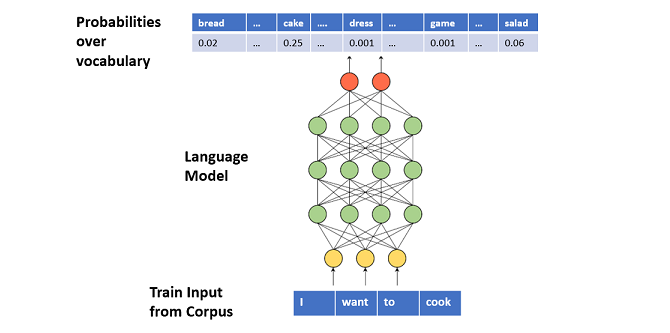

为了生成文本，我们可以重复下面的步骤：

* **Step 1:** 我们提供 **a sequence of words** 给 LM 作为模型的输入
* **Step 2:** LM 输出在 **vocabulary** 上的 **a conditional probability distribution**  
* **Step 3:** 我们从这个分布中 **sample** 一个 token
* **Step 4:** 我们 **concatenate** 新采样出来的 token ***generated text***
* **Step 5:** **a new input sequence** 被生成出来继续作为 LM 的输入


更多的信息可以参考 [Part A,  B, and C.](https://medium.com/mlearning-ai/text-generation-in-deep-learning-with-tensorflow-keras-f7cfd8d65d9e)

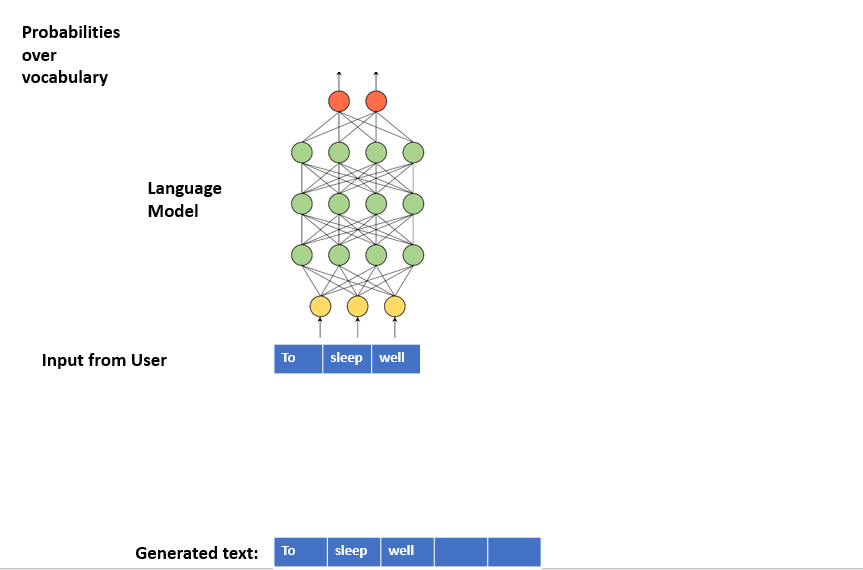

# NLG 解码策略
在文本生成中，  **sampling** 意味着根据生成的 **conditional probability distribution** 随机的 **picking** 下一个 token 

也就是说，在生成一个在 *vocabulary* 上的条件的概率分布之后，我们需要谨慎的决定如何从这个分布中 **select the next token** (***sample***)

这里有 **several methods for sampling** (see [here](https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277) 和 [here](https://huggingface.co/blog/how-to-generate)):

* **Greedy Search (Maximization)** 
* **Beam Search**
* **Temperature Sampling**
* **Top-K Sampling**
* **Top-P Sampling (Nucleus sampling)**


---
## 1. 训练一个语言模型


我们在下面的这些假设条件下，先来模拟一个条件概率分布

* 我们生成文本 **character-by-character**. 
* 我们有一个字符 **vocabulary** 从 **'a'** 到 **'z'**.
* 我们已经在一个 corpus 上训练了 **Language Model**
* 这样，语言模型已经能够根据一个输入序列生成一个在  **token vocabulary** 的 **conditional probability distribution** **token vocabulary** 
* 现在，我们想从 **conditional probability distribution** 中 **sample** (select) **next token**

让我们先来准备模拟的 LM


### 定义词典



In [2]:
dictionary =[]
for c in range(ord('a'), ord('z')+1):
    dictionary.append(chr(c))
dictionary

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

## 模拟一个已经被训练好的 LM

In [3]:
class language_model:
    def __init__(self, dictionary):
        self.dictionary = dictionary
    def predict(self):
        output= np.random.rand(len(dictionary))
        output=output/output.sum()
        return  output

model=language_model(dictionary)

## 模型生成的条件概率分布

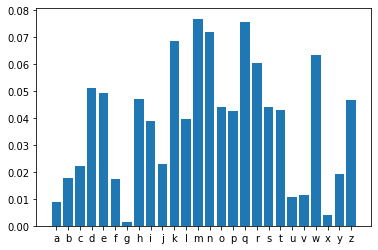

In [4]:
predictions= model.predict()
plt.bar(dictionary, predictions)
plt.show()

In [5]:
predictions.sum()

1.0

接下来，让我们来编写一些采样的方法来观察它们的行为

---
## 2. Greedy Search 解码

**Greedy search** 方法简单的 ***selects*** 选择那些 **highest probability** 作为它的下一个 token (*word or char*). 

然而，如果我们总是这样做的话，会让我们 **get stuck in loops** 

就比如这样子， “*I don’t know. I don’t know. I don’t know. I don’t know.*”

In [6]:
def greedy_search(conditional_probability):
    return (np.argmax(conditional_probability))

In [7]:
next_token = greedy_search(predictions)
print("Sampled token: ",dictionary[next_token])

Sampled token:  m


## 3. Beam Search 解码

另一种流行的启发式的方法就是，扩大 greedy search 的范围，返回一个最可能的列表作为输出。

不像贪心选择概率最高作为下一步的构成，beam search 把所有的下一步的可能性都保留下来，选择 k 个最有可能的。 k 是一个用户指定的参数，用来控制选择多少个 beams 或者并行搜索序列的概率。

在第一个 step 中，我们需要选择 k 个概率最高的单词作为第一步的输出

通常，beam width 是 1 的话就是一个 greedy search，通常在 machine translation 中我们选择 5 或者 10 作为 benchmark。更大的 beam widths 能够得到更好的性能，但是也会带来速度的降低。

这个搜索的过程会被停止当达到最大的长度，或者是达到一个 likelihood 的阈值。

让我们来举个具体的例子吧：

在每一步，每个候选的（candidate sequence） 被扩展成下一步的可能性。每一步的候选步骤都以概率乘积的形式打分，打分最高的 k 个序列被保留下来，其他的被裁剪掉，直到序列的结束。

概率值都是一些比较小的数值，并且乘积后得到的就是更小的数值。为了防止数值的 float 下溢，我们可以自然对数之和来进行代替，这样可以使数值更大便于管理。

下面我们来实现 beam_search_decoder()方法。

In [8]:
from math import log
from numpy import array
from numpy import argmax

def beam_search_decoder(data, k):
	sequences = [[list(), 0.0]]
	# 迭代序列中的每一步
	for row in data:
		all_candidates = list()
		# 计算每种 hypotheses 的分值，并存储到 all_candidates
		for i in range(len(sequences)):
			seq, score = sequences[i]
			for j in range(len(row)):
				candidate = [seq + [j], score - log(row[j])]
				all_candidates.append(candidate)
		# 对所有的候选序列，通过 score 排序
		ordered = sorted(all_candidates, key=lambda tup:tup[1])
		# 选择 K 个分 score 最高的
		sequences = ordered[:k]
	return sequences

In [9]:
n = 10

data = []
for i in range(10):
    prediction = model.predict()
    data.append(prediction)
    
print(data)
data = array(data)
result = beam_search_decoder(data, 5)

for seq in result:
	print(seq)

[array([0.04563779, 0.02161569, 0.04479185, 0.04562885, 0.05059144,
       0.0407983 , 0.04484077, 0.0370752 , 0.01768162, 0.02814935,
       0.02755992, 0.06248777, 0.02173917, 0.03760934, 0.0450678 ,
       0.06433954, 0.06199311, 0.0153244 , 0.01610208, 0.03928604,
       0.02779843, 0.02485483, 0.04621793, 0.05353387, 0.04339753,
       0.03587739]), array([0.01536682, 0.0322586 , 0.06697388, 0.04755681, 0.01985404,
       0.01176349, 0.07197202, 0.04416874, 0.07399065, 0.0692555 ,
       0.01400173, 0.03082868, 0.04058857, 0.00136049, 0.06158291,
       0.01056388, 0.01558958, 0.05686191, 0.06954863, 0.04547005,
       0.01573971, 0.03336443, 0.00686547, 0.02870433, 0.04271773,
       0.07305138]), array([0.02410912, 0.05053406, 0.06349842, 0.02155177, 0.00359775,
       0.00785557, 0.01632558, 0.06278149, 0.00645493, 0.01917329,
       0.07001586, 0.02091445, 0.01642112, 0.07741573, 0.08490701,
       0.038164  , 0.0710568 , 0.0028765 , 0.0085296 , 0.05853715,
       0.06657349, 

---
## 4. TEMPERATURE 采样

 
Temperature sampling 是受启发于统计热力学，***high temperature*** 就表示着有更高的概率会遭遇到低能量状态。

在概率模型中，**logits** 扮演了能量的角色，我们可以实现这种方法通过 **dividing logits by the temperature** 在把他们放到 ***softmax*** 之前，获取我们的采样概率。

## 4.1 绘制模型生成的条件概率分布



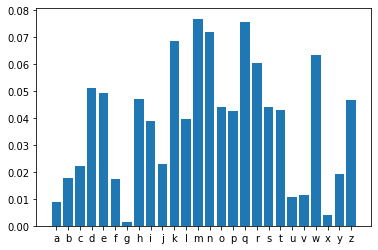

In [10]:
plt.bar(dictionary,predictions)
plt.show()

## 4.2 使用 “temperature” Reweighting 分布




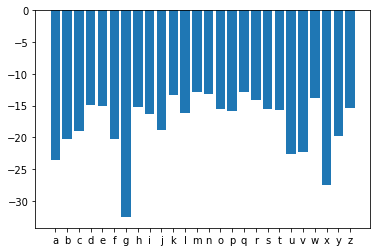

In [13]:
temperature=0.2
conditional_probability = np.asarray(predictions).astype("float64")
conditional_probability = np.log(conditional_probability) / temperature
plt.bar(dictionary,conditional_probability)
plt.show()

## 4.3 应用 softmax 函数

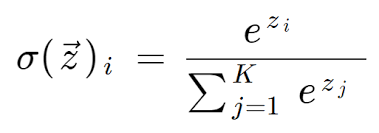

我们也可以使用 `scipy.special.softmax()` or `tf.keras.layers.Softmax()`. 

In [11]:
def softmax(z):
    return np.exp(z)/sum(np.exp(z))

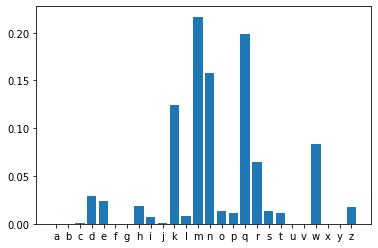

In [14]:
reweighted_conditional_probability = softmax(conditional_probability)
plt.bar(dictionary,reweighted_conditional_probability)
plt.show()

## 4.4 从 reweighted 的分布中，重新采样下一个字母

我们可以使用多项式分布进行采样 **multinomial distribution**. 

multinomial distribution 函数的  **parameters** 是: 
* **n**: int, Number of experiments.

* **pvals**: sequence of floats, length p. Probabilities of each of the p different outcomes. These must sum to 1 (however, the last element is always assumed to account for the remaining probability, as long as sum(pvals[:-1]) <= 1).

* **size**: int or tuple of ints, optional. Output shape. If the given shape is, e.g., (m, n, k), then m * n * k samples are drawn. Default is None, in which case a single value is returned.

我们可以调用方法 `(1, reweighted_conditional_probability, 1)` 因为我们只需要 **1 draw experiment** 从 **reweighted_conditional_probability** 选择 (sample) **1 output**. 

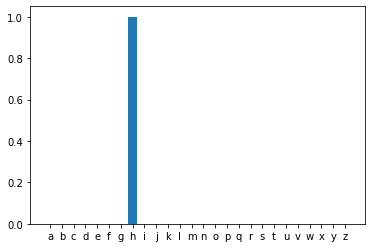

In [19]:
probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
plt.bar(dictionary,np.squeeze(probas))
plt.show()

## 4.5 把之前的操作放在一起

In [20]:
def temperature_sampling (conditional_probability, temperature=1.0):
    conditional_probability = np.asarray(conditional_probability).astype("float64")
    conditional_probability = np.log(conditional_probability) / temperature
    reweighted_conditional_probability = softmax(conditional_probability)
    probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
    plt.bar(dictionary,reweighted_conditional_probability)
    plt.show()
    return np.argmax(probas)

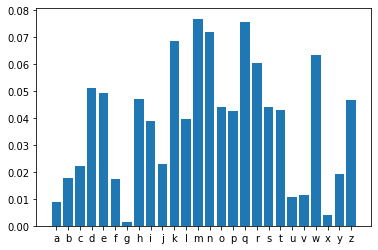

In [21]:
plt.bar(dictionary,predictions)
plt.show()

使用不同的 ***different temperature values***，可以得到不同的分布状况如下：

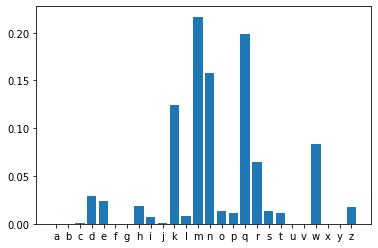

Temperature:  0.2
Sampled token:  w 



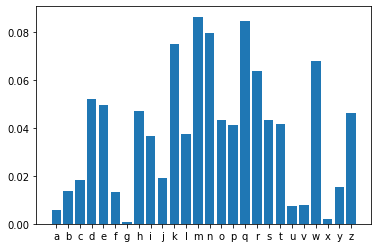

Temperature:  0.8
Sampled token:  h 



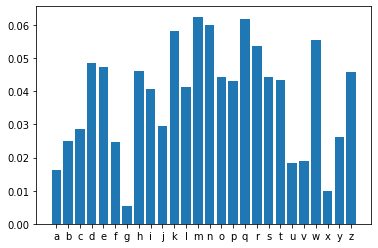

Temperature:  1.6
Sampled token:  c 



In [22]:
for temp in [0.2, 0.8, 1.6]:
    next_token = temperature_sampling(predictions, temperature=temp)
    print("Temperature: ", temp)
    print("Sampled token: ",dictionary[next_token],"\n")


## 4.6 一些观察后的结论
[在很多研究中](https://jjallaire.github.io/deep-learning-with-r-notebooks/notebooks/8.1-text-generation-with-lstm.nb.html), 都表明:


* 如果 **temperature** 被设置的 **very low values or 0**, Temperature Sampling 会成为 **equivalent** 一个 **Greedy Search**，每次都从最高的概率中选取

* 一个 **low temperature** 回导致 **repetitive** 和 **predictable** 的文本

* **higher temperatures**, 会让文本生成更加的 e **random**, **interesting**, **surprising**, 设置是 **creative**; 有的时候会创造一些新的词 (*misspelled words*) 会让人觉得 **plausible**. 

* trade-off 

# 5. TOP-K 采样

[Fan et. al (2018)](https://arxiv.org/abs/1805.04833) 介绍了一种非常简单的并且高效的采样方法，叫做 Top-K sampling  

在 Top-K sampling 中,  **K most likely next words** 被过滤，并且 **probability**  **redistributed** 这 k 个 token。

**GPT2** adopted this sampling scheme, which was one of the reasons for its success in **story generation**.

## 5.1 首先，我们有一个条件概率分布

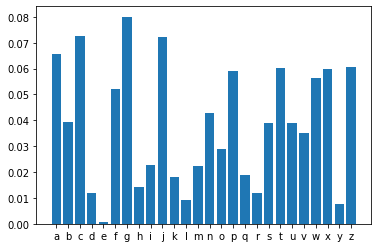

In [23]:
predictions= model.predict()
plt.bar(dictionary,predictions)
plt.show()

## 5.2 选择 top-k 分布

We can use `tf.math.top_k()` function to find the **k largest** entries in the vector and outputs their **values** and **indices** as vectors.

Using the **indices**, we can record the token names for plotting names of the tokens.



In [25]:
k=5
top_k_probabilities, top_k_indices= tf.math.top_k(predictions, k=k, sorted=True)
top_k_indices = np.asarray(top_k_indices).astype("int32")
top_k_tokens=[dictionary[i] for i in top_k_indices]
top_k_indices, top_k_tokens

(array([ 6,  2,  9,  0, 25], dtype=int32), ['g', 'c', 'j', 'a', 'z'])

## 5.3 应用 **softmax** 函数

In [26]:
top_k_redistributed_probability=softmax(np.log(top_k_probabilities))
top_k_redistributed_probability = np.asarray(top_k_redistributed_probability).astype("float32")
print('top_k_tokens: ',top_k_tokens)
print('top_k_redistributed_probability: ',top_k_redistributed_probability)
print('Total probability: ', top_k_redistributed_probability.sum())

top_k_tokens:  ['g', 'c', 'j', 'a', 'z']
top_k_redistributed_probability:  [0.22802848 0.20672853 0.20569912 0.18674056 0.17280333]
Total probability:  1.0


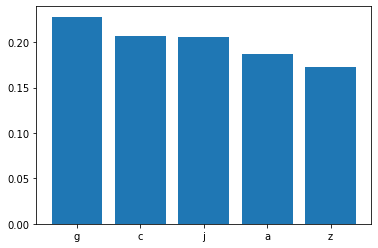

In [27]:
plt.bar(top_k_tokens,top_k_redistributed_probability)
plt.show()

## 5.4  从 reweighted 的分布中，重新采样下一个字母

In [28]:
sampled_token = np.random.choice(top_k_indices, 
                                 p=top_k_redistributed_probability)
print("Sampled token id: ",sampled_token, 
      " token: ",dictionary[sampled_token])

Sampled token id:  25  token:  z


## 5.5 把所有的步骤放在一起

In [29]:
def top_k_sampling(conditional_probability, k):
    top_k_probabilities, top_k_indices= tf.math.top_k(predictions, k=k, sorted=True)
    top_k_indices = np.asarray(top_k_indices).astype("int32")
    top_k_redistributed_probability=softmax(np.log(top_k_probabilities))
    top_k_redistributed_probability = np.asarray(top_k_redistributed_probability).astype("float32")
    sampled_token = np.random.choice(top_k_indices, p=top_k_redistributed_probability)
    top_k_tokens=[dictionary[i] for i in top_k_indices]
    plt.bar(top_k_tokens,top_k_redistributed_probability)
    plt.show()
    return sampled_token

Let's remember the predictions from the model once more:

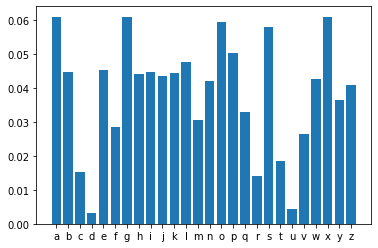

In [30]:
predictions= model.predict()
plt.bar(dictionary,predictions)
plt.show()

## 5.6 在使用 top-k 采样 **different k values**

We have the following updated conditional probability distributions over the vocabulary for the given k values:

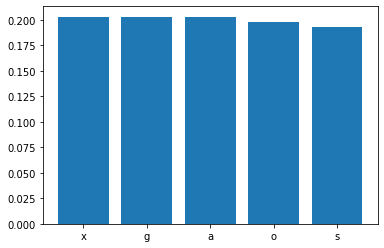

k:  5
Sampled token:  s 



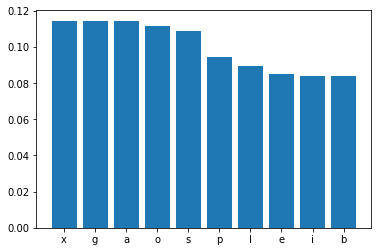

k:  10
Sampled token:  x 



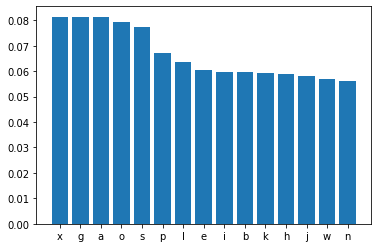

k:  15
Sampled token:  k 



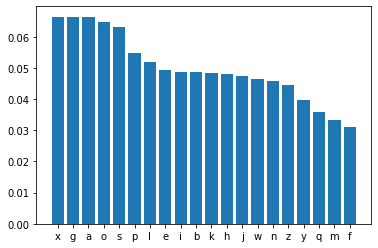

k:  20
Sampled token:  x 



In [31]:
for k in range(5, 25, 5):
    next_token = top_k_sampling(predictions, k=k)
    print("k: ", k)
    print("Sampled token: ",dictionary[next_token],"\n")

## 5.7 一些观察后的结论

研究表明, top-k sampling 能够 **improve quality** 通过 **removing the tail** 和有更少的可能性偏离主题。 

在一些场景中：
* there are **many tokens** we could sample from reasonably (***broad distribution***), and 

* in some cases, there are **few tokens** (***narrow distribution***).

因此, **k** 值的选择需要非常的 **carefully**.


# 6. Top-p 采样


* **Top-P Sampling (Nucleus sampling)**: Another way to exclude very low probability tokens is to include the most probable tokens that make up the “nucleus” of the probability mass function (PMF), such that the **sum of the most probable tokens just reaches** ***p***. In other words, based on a parameter 0<=p<=1, Top-P Sampling aggregates the **smallest set of words that have summed probability mass p**. It can be thought of as a variation of top-k sampling with dynamic k. For details check [this blog](https://medium.com/ai2-blog/a-guide-to-language-model-sampling-in-allennlp-3b1239274bc3).


https://github.com/huggingface/transformers/blob/7959d835996d3c019b9cc9820982f7bf501fb876/src/transformers/generation_tf_utils.py#L1010


In [32]:
def scatter_values_on_batch_indices(values, batch_indices):
    shape = shape_list(batch_indices)
    # broadcast batch dim to shape
    broad_casted_batch_dims = tf.reshape(tf.broadcast_to(tf.expand_dims(tf.range(shape[0]), axis=-1), shape), [1, -1])
    # transform batch_indices to pair_indices
    pair_indices = tf.transpose(tf.concat([broad_casted_batch_dims, tf.reshape(batch_indices, [1, -1])], 0))
    # scatter values to pair indices
    return tf.scatter_nd(pair_indices, tf.reshape(values, [-1]), shape)


def set_tensor_by_indices_to_value(tensor, indices, value):
    # create value_tensor since tensor value assignment is not possible in TF
    value_tensor = tf.zeros_like(tensor) + value
    return tf.where(indices, value_tensor, tensor)


def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

In [33]:
def top_p_decoding(logits, top_p=1.0, filter_value=-float("Inf"), min_tokens_to_keep=1):
    sorted_indices = tf.argsort(logits, direction="DESCENDING")
    sorted_logits = tf.gather(
        logits, sorted_indices, axis=-1, batch_dims=1
    )  # expects logits to be of dim (batch_size, vocab_size)

    cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)

    # Remove tokens with cumulative probability above the threshold (token with 0 are kept)
    sorted_indices_to_remove = cumulative_probs > top_p

    if min_tokens_to_keep > 1:
        # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
        sorted_indices_to_remove = tf.concat(
            [
                tf.zeros_like(sorted_indices_to_remove[:, :min_tokens_to_keep]),
                sorted_indices_to_remove[:, min_tokens_to_keep:],
            ],
            -1,
        )

    # Shift the indices to the right to keep also the first token above the threshold
    sorted_indices_to_remove = tf.roll(sorted_indices_to_remove, 1, axis=-1)
    sorted_indices_to_remove = tf.concat(
        [tf.zeros_like(sorted_indices_to_remove[:, :1]), sorted_indices_to_remove[:, 1:]],
        -1,
    )
    # scatter sorted tensors to original indexing
    indices_to_remove = scatter_values_on_batch_indices(sorted_indices_to_remove, sorted_indices)
    logits = set_tensor_by_indices_to_value(logits, indices_to_remove, filter_value)
    return logits

In [34]:
n = 10

data = []
for i in range(10):
    prediction = model.predict()
    data.append(prediction)
data = array(data)
print(data)
result = top_p_decoding(data, 0.5)

for seq in result:
	print(seq)

[[2.26126902e-03 5.31604977e-02 6.36059852e-02 2.18981195e-02
  2.93753465e-02 6.87441791e-02 5.03705946e-02 7.45039206e-03
  5.53574830e-02 6.08108192e-02 4.55345153e-02 2.17048934e-02
  4.97700134e-02 3.96664999e-02 6.47220436e-02 3.16307158e-03
  4.53145368e-02 6.36954716e-02 1.87088688e-02 6.39819776e-02
  3.59466924e-02 1.44335933e-02 1.07934203e-02 5.70805633e-02
  1.80601742e-02 3.43889788e-02]
 [7.04407559e-02 1.11804228e-02 2.36361394e-02 2.46110277e-04
  6.28815019e-02 2.09295519e-02 7.40631277e-02 3.73437654e-02
  6.08061274e-02 7.10325435e-02 2.38553372e-02 1.43776429e-02
  1.57411089e-02 5.24055474e-02 2.67824008e-02 3.80302260e-02
  5.94734000e-02 2.21202573e-02 1.71026215e-02 4.71083872e-02
  5.27274642e-02 1.78503028e-02 1.20039027e-02 5.12050307e-02
  7.29775907e-02 4.36787336e-02]
 [6.87671282e-02 5.53179835e-02 3.01809125e-02 3.41376099e-02
  7.61425853e-03 3.84259688e-02 1.72433918e-02 3.19021197e-02
  3.91949365e-02 4.12725715e-02 5.68270158e-02 2.66742742e-05
  6.